In [1]:
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt
import cmapy

In [2]:
def partial_shadow(sun_radius):
    arr = np.linspace(0, 2, sun_radius * 2 + 1)
    arr = np.delete(arr + (arr[1] - arr[0]) / 2, -1)
    shadow_arr = (np.arccos(1 - arr) - (1 - arr) * np.sqrt(2 * arr - arr ** 2)) / np.pi

    return shadow_arr

True

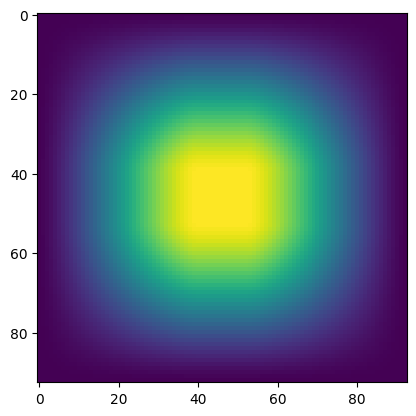

In [9]:
# partial shadow distance is 2r of the sun

def solar_cell_mask(cell_size, distance, pix_deg, sun_radius):
    cell_x = cell_size[0]
    cell_y = cell_size[1]

    projection_x = int(2 * math.degrees(math.atan(cell_x / distance / 2)) * pix_deg)
    projection_y = int(2 * math.degrees(math.atan(cell_y / distance / 2)) * pix_deg)
    projection = [projection_x, projection_y]
    
    size_x = projection_x + 2 * sun_radius
    size_y = projection_y + 2 * sun_radius

    mask = np.ones((size_x, size_y))

    shadow_arr = partial_shadow(sun_radius)

    mask[0:sun_radius * 2, :] *= shadow_arr[:, None] # top
    mask[-sun_radius * 2:,:] *= np.flip(shadow_arr)[:, None] # bottom
    mask[:, 0:sun_radius * 2] *= shadow_arr[None, :] # left
    mask[:,-sun_radius * 2:] *= np.flip(shadow_arr)[None, :] # right

    return projection, mask

cell_mask = solar_cell_mask([0.21,0.21], 14, 4048/65, 20)[1]
plt.imshow(cell_mask)
cv2.imwrite('doc_pictures/cell_mask.png', cell_mask*255)


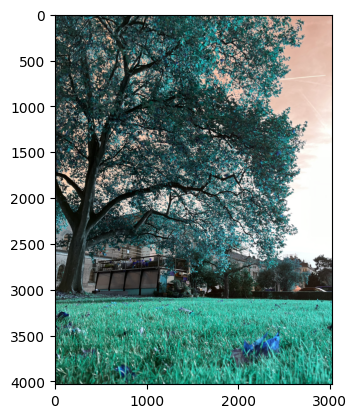

In [4]:
filename = input("Filename: ")
tree_img = cv2.imread('measuredTrees/' + filename)
plt.imshow(tree_img)

In [5]:
distance = 5
pos_az = 10

variation = 200

sun_radius_deg = 0.533

res_x = tree_img.shape[1]
res_y = tree_img.shape[0]
pix_deg = res_x / 65

sun_radius = int(sun_radius_deg * pix_deg) // 2

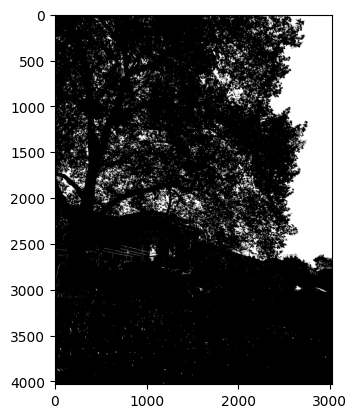

In [6]:
lower_bound = np.array([200, 0, 0])
upper_bound = np.array([360, 255, 255])

mask = cv2.inRange(tree_img, lower_bound, upper_bound)

#cv2.imshow('treemask', imagemask)
plt.imshow(mask, cmap='gray')

In [7]:
def get_slices_from_coords(mask, mask_coords):
    res_masks = []
    for row in mask_coords:
        res_row = []
        for cell in row:
            res_row.append(mask[cell[0]:cell[2], cell[1]:cell[3]])
        res_masks.append(res_row)
    return np.array(res_masks)


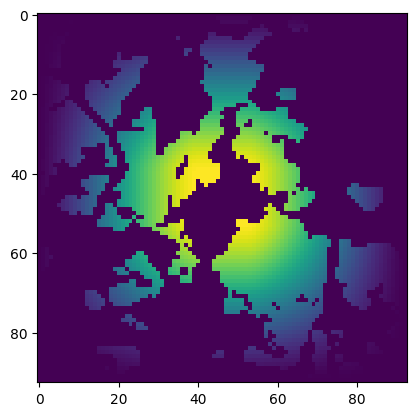

In [8]:
def solar_module_masks(cell_size, shape, spacing, pos, mask, distance, pix_deg, sun_radius):

    cell_projection, cell_mask = solar_cell_mask(cell_size, distance, pix_deg, sun_radius)

    spacing_projection = np.int_(np.multiply(cell_projection, int(spacing * 1000000)) / cell_size / 1000000)

    size = shape * (cell_projection + spacing_projection)
    start_pos = pos - size / 2

    unit_projection = cell_projection + spacing_projection

    pos_arr = np.array(np.meshgrid(np.arange(0.5, shape[0] + 0.5), np.arange(0.5, shape[1] + 0.5))).T.reshape(shape[0],shape[1],2) * unit_projection + start_pos

    cell_mask_size = np.array(cell_mask.shape)

    mask_coords = np.int_(np.concatenate((pos_arr - cell_mask_size / 2, pos_arr + cell_mask_size / 2), axis=2))

    tree_mask_slices = get_slices_from_coords(mask, mask_coords) / 255

    combined_masks = tree_mask_slices * cell_mask

    radiation_on_cells = (np.apply_over_axes(np.sum, combined_masks, [2,3]) / np.sum(cell_mask)).reshape(len(combined_masks),-1)

    return radiation_on_cells, combined_masks

plt.imshow(solar_module_masks([0.21, 0.21], [12, 6], 0.04, [1673, 2189], mask, 14, 4048/65, 20)[1][9][2])